# Text Classification Challenge

## Objective:
A basic task in classifying mobile applications is to group them into different categories, with the further
purpose of identifying similarities between them in order to understand user behavior.
In this task, we intend to create a service which classifies applications to groups (segments), based on the
description given by the app creator.

## This Notebook
This Notebook is the place I investigate the dataset, trying different approaches and classifiers in order to get the best possible result with the time given me. In the end of this notebook you can see the results of the classifier I picked up for the task.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from langdetect import detect_langs
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.naive_bayes import MultinomialNB
import pickle

from operator import itemgetter

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# load dataset

In [2]:
df_ex = pd.read_excel(open('appDescriptions.xlsx','rb'), sheetname='Examples')
original_num_rows = df_ex.shape[0]
df_ex.head()

,appId,package,appName,segment,description
0,8218876735178300,ru.smsfinance,смсфинанс быстрые займы онлайн,Finance,"[ смсфинанс } помогает вам каждый раз, когда д..."
1,12956406968201529,com.tencent.ibg.joox,JOOX Music,Arts & Entertainment,"JOOX is here, it’s the FREE music streaming ap..."
2,14001276947357815,com.cmcm.flashlight,"CM Flashlight (Compass, SOS)",Personalization & Productivity,This simple and practical flashlight tool is t...
3,14289825651881422,com.NowaEra.MobiBlum.WesolyLas,Mobi Blum: Wesoły Las,Education,"Leśne domki czekają, aż je umeblujesz! Wybierz..."
4,17734052595911731,com.allryder.android,"ally – Fahrpläne, Routen, Bahn",Vehicles,Ally brings together all your transport option...


# Filter English-only apps

use google's english-lang detector to filter the english-only descriptions we want to train our classifier on

In [3]:
# filter english only descriptions
def isEnglish(s):
    try:
        detection = detect_langs(s[:50])
        lang_obj = detection[0]
        return (lang_obj.lang=='en' and lang_obj.prob>0.95)
    except:
        return False

    
df2 = df_ex[df_ex['description'].apply(isEnglish)]
#df2.to_csv('test.csv', sep=',', encoding='utf-8')
num_of_rows = df2.shape[0]
print ('number of rows in dataset {} ({}% after preprocessing)'.format(
            num_of_rows, 
            int(100.0*num_of_rows/original_num_rows)))

number of rows in dataset 901 (60% after preprocessing)


# Filter segments with too few examples to train on

There are 22 segments originally in the dataset but there are segments like "Home & Garden" with several examples and we can't expect any classifier to be able to train on those segments and expect high performance. 
Let's cut the segments that have too few number of examples and override our DataFrame. 

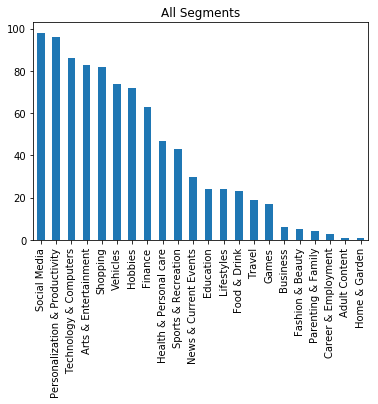

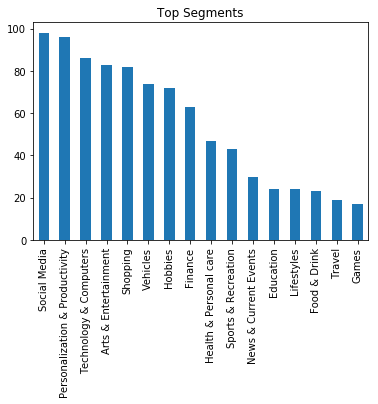

In [4]:
prob = df2['segment'].value_counts()
prob.plot(kind='bar')
plt.xticks(rotation=90)
plt.title("All Segments")
plt.show()

thres = 10
prob = prob[prob>thres]

prob.plot(kind='bar')
plt.xticks(rotation=90)
plt.title("Top Segments")
plt.show()

allowed_sements = prob.index.tolist()

df2 = df2.loc[df2['segment'].isin(allowed_sements)]




# split to training and testing data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df2, df2['segment'], test_size=.10, random_state=32)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(792, 5) (792,)
(89, 5) (89,)


# Tokenize the corpus with Tf-IDF

tf-idf vectorization of a corpus of text documents assigns each word 
in a document a number that is proportional to its frequency in the 
document and inversely proportional to the number of documents in 
which it occurs.


In [6]:

vectorizer = TfidfVectorizer(
                        use_idf=True,
                        norm=None,
                        smooth_idf=True,
                        sublinear_tf=False, 
                        binary=False,
                        min_df=1, 
                        max_df=.2, # ignore very commmon terms
                        max_features=None,
                        strip_accents=None, 
                        ngram_range=(1,1),
                        preprocessor=None,              
                        stop_words=ENGLISH_STOP_WORDS, 
                        tokenizer=None, 
                        vocabulary=None
             )
counts = vectorizer.fit_transform(X_train['description'].values)
#idf = vectorizer.idf_
#print dict(zip(vectorizer.get_feature_names(), idf))

# Train the Classifier 
We’re going to use a naïve Bayes classifier to learn from the features. 
A naïve Bayes classifier applies the Bayes theorem with naïve independence 
assumptions. That is, each feature (in this case word counts) is independent 
from every other one and each one contributes to the probability that an 
example belongs to a particular class.

In [7]:

classifier = MultinomialNB()
 
# train
targets = y_train.values
classifier.fit(counts, targets)

# save
with open(b"model.pcl","wb") as f:
    pickle.dump((classifier, vectorizer),f)

    
classifier.classes_

array([u'Arts & Entertainment', u'Education', u'Finance', u'Food & Drink',
       u'Games', u'Health & Personal care', u'Hobbies', u'Lifestyles',
       u'News & Current Events', u'Personalization & Productivity',
       u'Shopping', u'Social Media', u'Sports & Recreation',
       u'Technology & Computers', u'Travel', u'Vehicles'],
      dtype='<U30')

# Top words used to identify the segments

Let's find out what words from our vocabulary are used to identify each of our segments (classes). It's important to see that common words like 'of', 'the', 'for' etc are not used by the classifier (!!) to decide the classes. 

feature_count shape (16, 17570),


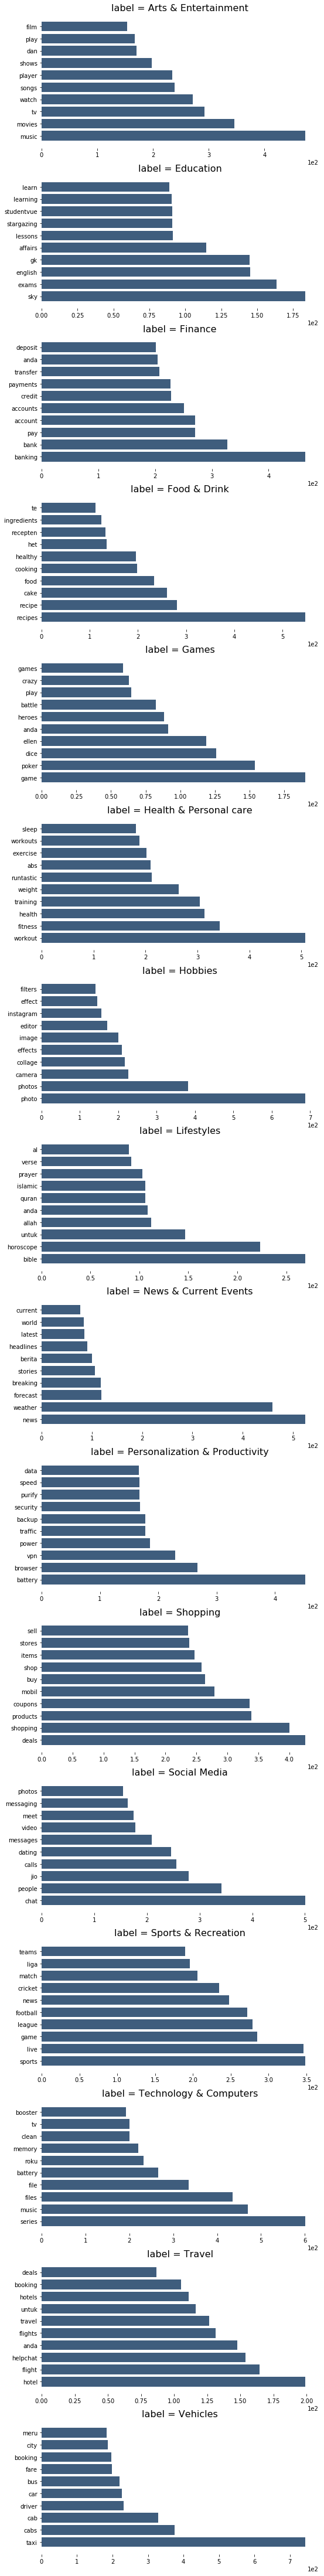

In [8]:
feature_count_ = classifier.feature_count_
print ("feature_count shape {},".format(feature_count_.shape)) 

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

features = vectorizer.get_feature_names()
dfs = []
for i, segment in enumerate(classifier.classes_):
    #print ('Most important words for \"{}\"'.format(segment))
    df = top_tfidf_feats(feature_count_[i], features, 10)
    df['label'] = segment
    dfs.append(df)
    
w = 1
h = int(len(classifier.classes_)/w)

fig = plt.figure(figsize=(8,70), facecolor="w")
x = np.arange(len(dfs[0]))
for i, df in enumerate(dfs):
    ax = fig.add_subplot(h, w, i+1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    #ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title("label = " + str(df.label[0]), fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    yticks = ax.set_yticklabels(df.feature)
    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
plt.show()

# Let's try the classifier with some examples 
This is not an indication for performance but to see some reason in the classifier's decision.

In [9]:

def print_pred (pred):
    print ("--> Category \"{}\", probability {}".format(*pred))

def predict_section (string):
    print ('Prediction for \"{}\"'.format(string))
    _input = vectorizer.transform([string])
    predictions = (zip(classifier.classes_, classifier.predict_proba(_input)[0]))
    newlist = sorted(predictions, key=itemgetter(1), reverse=True) 
    print_pred (newlist[0])
    print_pred (newlist[1])
    print_pred (newlist[2])
    print_pred (newlist[3])
    print_pred (newlist[4])
    print

predict_section('Pro Version of the best mp3 downloader app from Copyleft engines.')
predict_section('The Official Microsoft Outlook.com app gives you the best mobile experience for your Outlook.com account. Sign in using your existing Microsoft account, which is usually y')
predict_section('Flipboard is your personal magazine. Used by millions of people everyday, it’s a single place to keep up on the news, follow topics you care about and share stories, videos and p')

Prediction for "Pro Version of the best mp3 downloader app from Copyleft engines."
--> Category "Technology & Computers", probability 0.999263201994
--> Category "Arts & Entertainment", probability 0.000736798005655
--> Category "Personalization & Productivity", probability 3.0024325462e-25
--> Category "Lifestyles", probability 2.07742913505e-25
--> Category "Hobbies", probability 1.6162382187e-27

Prediction for "The Official Microsoft Outlook.com app gives you the best mobile experience for your Outlook.com account. Sign in using your existing Microsoft account, which is usually y"
--> Category "Personalization & Productivity", probability 1.0
--> Category "Hobbies", probability 1.39976283722e-15
--> Category "Technology & Computers", probability 8.27097681216e-16
--> Category "Finance", probability 4.11212803027e-22
--> Category "Travel", probability 7.03705303909e-25

Prediction for "Flipboard is your personal magazine. Used by millions of people everyday, it’s a single place to k

# Classifier performance

Get metrics: Accuracy, Precision and Recall. Print the confusion metric for later analysis.

Accuracy is 0.741573033708
Precision is 0.750564229778
Recall is 0.741573033708
Classification report on test set for classifier:
                                precision    recall  f1-score   support

          Arts & Entertainment       0.67      0.67      0.67         9
                     Education       0.67      0.67      0.67         3
                       Finance       0.71      1.00      0.83         5
                  Food & Drink       0.75      1.00      0.86         3
                         Games       0.00      0.00      0.00         2
        Health & Personal care       1.00      1.00      1.00         3
                       Hobbies       0.75      0.86      0.80         7
                    Lifestyles       1.00      0.67      0.80         3
         News & Current Events       0.75      1.00      0.86         3
Personalization & Productivity       0.73      0.89      0.80         9
                      Shopping       1.00      0.50      0.67        10
     

sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


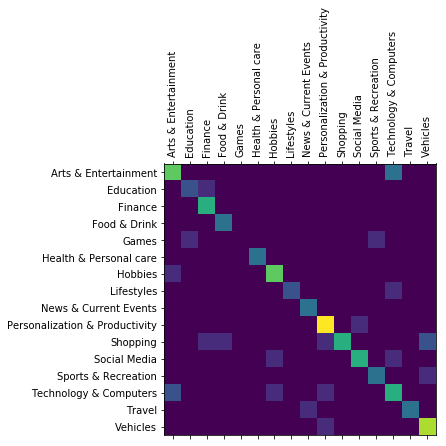

In [10]:
labels = classifier.classes_.tolist()

X_test_tokened = vectorizer.transform(X_test['description'].values)
predicted = classifier.predict(X_test_tokened)

print ('Accuracy is {}'.format(accuracy_score (y_test.values, predicted)))

print ('Precision is {}'.format(
    precision_score(y_test.values, predicted, average='weighted')
))

print ('Recall is {}'.format(recall_score(y_test.values, predicted, average='weighted')))

print("Classification report on test set for classifier:")
print(classification_report(y_test.values, predicted,
                                target_names=classifier.classes_))




cm = confusion_matrix(y_test.values, predicted, labels)
width, height = cm.shape

# Show confusion matrix
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(cm)

#ax.set_xlabel('Predicted')
#ax.set_ylabel('True')
ax.set_xticks(range(width))
ax.set_yticks(range(height))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# See what are we failing on
get 10 test cases that we fail on. try to understand why and what can we do better to minize it.

In [11]:
# review the results
failed_test_markers = y_test.values != predicted
failed_test = X_test[failed_test_markers][['appName','description','segment']]
failed_test['prediction'] = predicted[failed_test_markers]

for ii, r in failed_test[:10].iterrows():
    print ("Classified \"{}\" as \"{}\" but it's realy \"{}\"".format(
        r['description'].encode('utf-8'), 
        r['prediction'],
        r['segment']
    ))
    print

Classified "Short on time and always on the go? Download the SUBWAY® App to find a store, order your meal and pay ahead, all from your phone. Currently available in participating locations across the U.S..- Find: Use your phone to find a SUBWAY® Restaurant wherever you are!- Order: Place an order and pay ahead and it’ll be ready for pick up in just 15 minutes. Your order history is saved to make it even easier the next time you order!- Pay: Use your phone to pay for your order when you’re in a SUBWAY® Restaurant.Please note: Remote ordering available for participating restaurants. For any questions you can contact us here: AppFeedback@subway.comSUBWAY® is a registered trademark of Doctor’s Associates Inc. © Doctor’s Associates Inc. All Rights Reserved" as "Vehicles" but it's realy "Shopping"

Classified "With this free app, you can easily view playlists on YouTube. This app has a really nice and fast user interface, which you may prefer over the official YouTube app." as "Arts & Entert

# Export prediction to the "Classify" sheet to "apps.csv"

In [12]:
# create app.csv from the 'Classify' tab 

df_cl = pd.read_excel(open('appDescriptions.xlsx','rb'), sheetname='Classify')

def predict (x):
    if not isEnglish(x):
        return "Not supported language"
    else:
        xv = vectorizer.transform([x])
        return classifier.predict(xv)[0]
 
df_cl['prediction'] = df_cl['description'].map(predict)
df_cl.to_csv('apps.csv', sep=',', encoding='utf-8')
df_cl.head()

,appId,package,appName,description,prediction
0,4780511369165538261,com.outlook.Z7,Outlook.com,The Official Microsoft Outlook.com app gives y...,Personalization & Productivity
1,4780957067162908698,de.handelsblatt.hb10,Handelsblatt10 - Top10 News,Braucht die Welt echt noch eine weitere News-A...,Not supported language
2,4785615956890702214,com.radiojavan.androidradio,Radio Javan,The best Persian music and entertainment from ...,Arts & Entertainment
3,4786726634047601738,ee.mtakso.client,Taxify,Here's how the app works:1. Set the location a...,Social Media
4,4787364423336312358,com.opentaxi.android,Такси в България,С това безплатно приложение можете да повикате...,Not supported language


# Resolution

## Dataset

I started with understanding the data I had - first of all, this dataset is small. After the Language filtering I found that ~40% of the data was not in english. So, I dropped it... It left me with really small amount of apps to train any classifier on.

## Strategy

I saw that there are segments with very smalls amounts of examples - for example: Adult content, Home & Garden etc... I chose to *discard those segments* due to bias it creates.
I chose a *bag-of-words approach* with CountVectorizer but than I moved to *TfidfVectorizer* to enhace results. I started using the *stop-word* in the vectorizer when I realized that very common words are used in the classifier (words like 'of', 'a', 'the' etc). So I added the stop-words and the idf threshold to filter very common words. 

## Accuracy, Precision and Recall

The accuracy is about 74%.

Average precision is about 75% - The best precision segments are *Health, Lifestyle, Shopping and Travel* - those segments have distinct words that identify them (unlike *Tech* - that have a high overlap ratios). This is why we see high precision rates with distinct semgnets like Health and Travel and not in Tech for instance.  

Average recall is about 74% - For my optinion, the main cause is the *subjectiveness and overlapping* of the labeld data. Because lots of Apps can relate to several segments we see this degraded recall precentage; segments like Tech and Entertainment can related to many other apps and vice versa. Another consideration is that each app was labeled by a different creator, which means that his opinion may be different on how he/she "understands" a segment.


## How to make results better
 
- Data: Need more quality data! 40% of the dataset was not english and there were segments with really small amount of examples.

- Classifier: Enhance the results with K-Fold approach.
 
- Different Classifier: I would train a LSTM deep network classifier to include the sequence of words instead of looking at in as a bag-of-words
